# import

In [1]:
import os
import sys

In [2]:
from config import *

sys.path.append(os.path.normpath('../../src'))
from experiment_cost import AGG_COST
from util import fix_plot

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Run Experiment

In [4]:
import warnings
warnings.simplefilter('ignore', pd.io.pytables.PerformanceWarning)
warnings.filterwarnings('ignore', message='ks_2samp')

In [ ]:
for dataset in DATASETS:
    for detector in ALL_DETECTORS:
        runner = EX_RUNNERS[detector](
            base_data_dir=INTERIM_DATA_DIR,
            save_dir=SAVE_DATA_DIR,
            dataset_name=dataset,
            detector_name=detector,
            detector_cls=ALL_DETECTORS[detector],
            base_data_type=BASE_DATA_TYPE)
        runner.run_experiment(detector_prms=DETECTOR_PRMSS[detector], show_progress=True)

# results

In [5]:
SAVE_TO_FILE = False
SAVE_EXT = '.eps'

In [6]:
train_size = 1000  # TODO

In [7]:
dfs = []
for dataset in DATASETS:
    for detector in ALL_DETECTORS:
        agg = AGG_COST(SAVE_DATA_DIR, dataset, detector)
        df = agg.results
        df['dataset'] = dataset
        df['method'] = detector
        df['len'] = pd.read_csv(df['base_path'][0]).shape[0]
        dfs.append(df)
df_base = pd.concat(dfs)
df_base['time'] = df_base['time'].astype(float)

## 

In [8]:
df = df_base.copy()
df['time'] = df['time'] / (df['len'] - train_size)
df = df.pivot(index='method', columns='dataset', values='time')
df = df.loc[list(ALL_DETECTORS)]

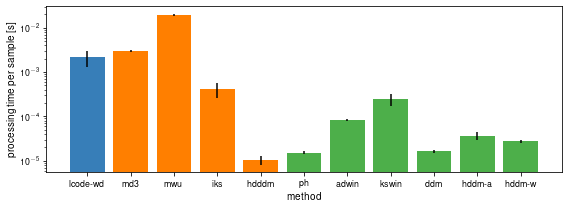

In [9]:
save_path = os.path.join(OUTPUT_DIR, 'processing time')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.bar(x=df.index.str.replace('_', '-'), height=df.mean(axis=1), yerr=df.std(axis=1), 
       color=[COLORS[DETECTOR_TYPES[method]] for method in df.index])
ax.set_xlabel('method')
ax.set_ylabel('processing time per sample [s]')
plt.yscale('log')
fix_plot(plt, True, None, None, SAVE_TO_FILE, save_path, SAVE_EXT)

## 

HDDDM is batch-based method and runs only every train_size (batch size). Therefore, the following comparison may be better.

In [10]:
df = df_base.copy()
df.loc[df['method'] != 'hdddm', 'time'] = df[df['method'] != 'hdddm']['time'] / (df[df['method'] != 'hdddm']['len'] - train_size)
df.loc[df['method'] == 'hdddm', 'time'] = df[df['method'] == 'hdddm']['time'] / (df[df['method'] == 'hdddm']['len'] // train_size - 1)
df = df.pivot(index='method', columns='dataset', values='time')
df = df.loc[list(ALL_DETECTORS)]

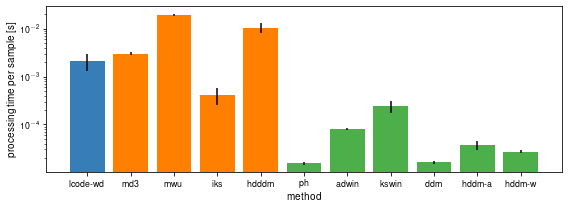

In [11]:
save_path = os.path.join(OUTPUT_DIR, 'processing time')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.bar(x=df.index.str.replace('_', '-'), height=df.mean(axis=1), yerr=df.std(axis=1), 
       color=[COLORS[DETECTOR_TYPES[method]] for method in df.index])
ax.set_xlabel('method')
ax.set_ylabel('processing time per sample [s]')
plt.yscale('log')
fix_plot(plt, True, None, None, SAVE_TO_FILE, save_path, SAVE_EXT)